In [1]:
import qiskit

from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from pylatexenc.latex2text import *
import qiskit_ibm_runtime

from qiskit_aer import AerSimulator
import qiskit_aer as Aer

from PIL import Image

from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

from qiskit_aer.primitives import SamplerV2
from qiskit import QuantumCircuit
from qiskit.visualization import array_to_latex

In [2]:
# Function to compute the distance between 2 black-and-white images

def ImageDistance(Im1, Im2):
    if Im1.shape != Im2.shape:
        raise ValueError("Arrays must have the same shape")

    sh = Im1.shape
    d = sh[0]*sh[1]


    return 100*np.sum(Im1 != Im2)/d

# Small BW Image

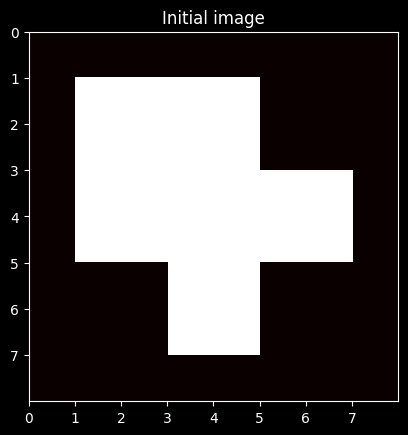

In [4]:
img = np.array([  [0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 0, 0, 0],
                  [0, 1, 1, 1, 1, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 0, 0, 0],
                  [0, 0, 0, 1, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0] ])


# plot image function

def plot_image(Image, title):
    plt.title(title)
    plt.xticks(range(Image.shape[0]))
    plt.yticks(range(Image.shape[1]))
    plt.imshow(Image, extent=[  0,Image.shape[0], Image.shape[1],0,], cmap='hot')
    plt.show()

plot_image(img, 'Initial image')

In [5]:
def amplitude_encode(img_data):

    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))

    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)

    # Return the normalized image as a numpy array
    return np.array(image_norm)


#we now normalize image and get coefficients in both horizontal and vertical directions

# Horizontal: Original image
h_norm_image = amplitude_encode(img)

# Vertical: Transpose of Original image
v_norm_image = amplitude_encode(img.T)

In [6]:
data_q = 6
ancillary_q = 1
total_q = data_q + ancillary_q

# Initialize the amplitude permutation unitary
Amp_permutation_unitary = np.identity(2**total_q)
print(Amp_permutation_unitary)
Amp_permutation_unitary=np.roll(Amp_permutation_unitary,1,axis=1)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


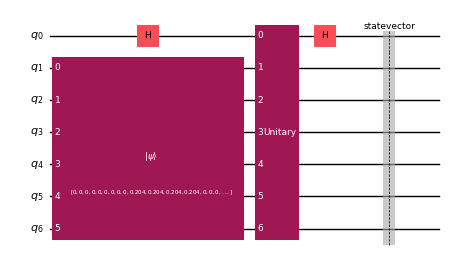

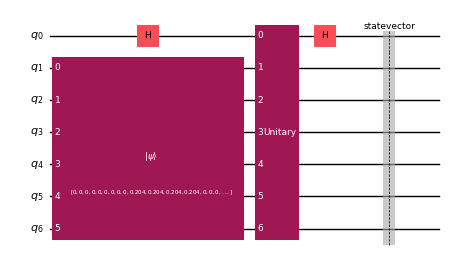

In [7]:
qc_h = QuantumCircuit(total_q)
qc_h.initialize(h_norm_image, range(1, total_q))
qc_h.h(0)
qc_h.unitary(Amp_permutation_unitary, range(total_q))
qc_h.h(0)
qc_h.save_statevector()

display(qc_h.draw('mpl', fold=-1, scale = 0.5))


# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_q)
qc_v.initialize(v_norm_image, range(1, total_q))
qc_v.h(0)
qc_v.unitary(Amp_permutation_unitary, range(total_q))
qc_v.h(0)
qc_v.save_statevector()

display(qc_v.draw('mpl', fold=-1, scale = 0.5))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list).result()

state_vector_h = results.get_statevector(qc_h)
state_vector_v = results.get_statevector(qc_v)

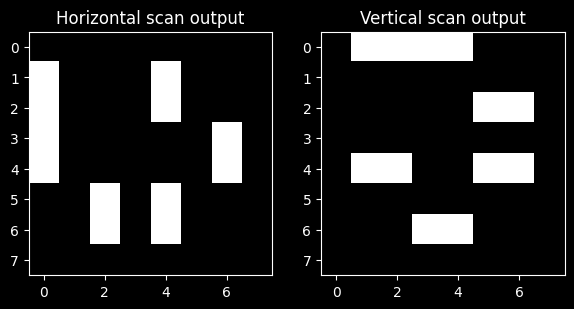

In [8]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img = np.abs(np.array([1 if threshold(state_vector_h[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8)
v_edge_scan_img= np.abs(np.array([1 if threshold(state_vector_v[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(h_edge_scan_img, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

plt.tight_layout()

# Show the plot
plt.show()


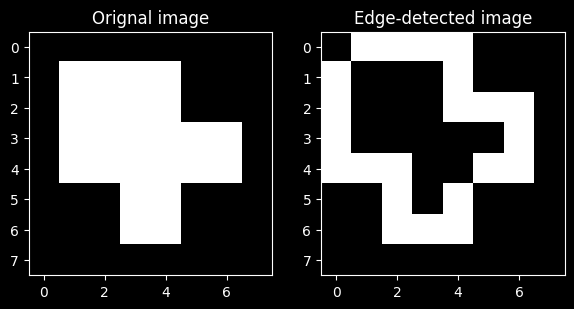

In [9]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image = h_edge_scan_img | v_edge_scan_img

# Plotting the Original and edge reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Orignal image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image, cmap='gray')
axes[1].set_title('Edge-detected image')
axes[1].axis('on')

plt.tight_layout()

# Show the plot
plt.show()

## Single bit-flip error

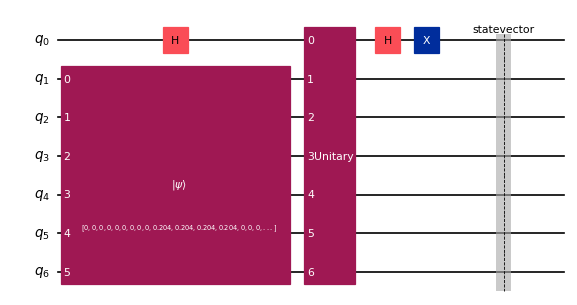

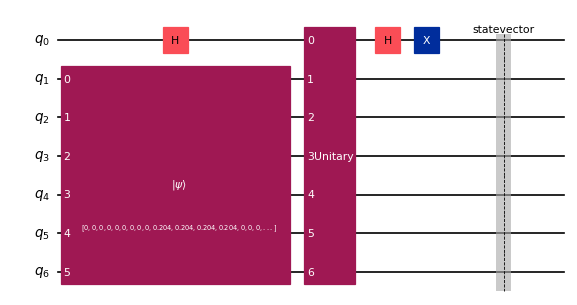

In [10]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_q)
qc_h.initialize(h_norm_image, range(1, total_q))
qc_h.h(0)
qc_h.unitary(Amp_permutation_unitary, range(total_q))
qc_h.h(0)

qc_h2 = qc_h.copy()
qc_h2.x(0)        # Bit flip error on the first qubit



qc_h.save_statevector()
qc_h2.save_statevector()

display(qc_h2.draw('mpl', fold=-1, scale = 0.6))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_q)
qc_v.initialize(v_norm_image, range(1, total_q))
qc_v.h(0)
qc_v.unitary(Amp_permutation_unitary, range(total_q))
qc_v.h(0)

qc_v2 = qc_v.copy()

qc_v2.x(0)        # Bit flip error on the first qubit

qc_v.save_statevector()
qc_v2.save_statevector()

display(qc_v2.draw('mpl', fold=-1, scale = 0.6))

# Combine both circuits into a single list
circ_list2 = [qc_h2, qc_v2]


# Simulating cirucits
simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list2).result()

state_vector_h2 = results.get_statevector(qc_h2)
state_vector_v2 = results.get_statevector(qc_v2)

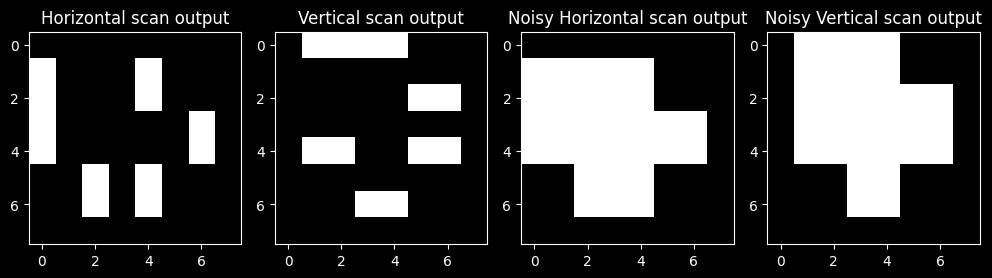

In [11]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img2 = np.abs(np.array([1 if threshold(state_vector_h2[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8)
v_edge_scan_img2= np.abs(np.array([1 if threshold(state_vector_v2[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Plot the images in the respective subplots
axes[0].imshow(h_edge_scan_img, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

axes[2].imshow(h_edge_scan_img2, cmap='gray')
axes[2].set_title('Noisy Horizontal scan output')
axes[2].axis('on')

axes[3].imshow(v_edge_scan_img2, cmap='gray')
axes[3].set_title('Noisy Vertical scan output')
axes[3].axis('on')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

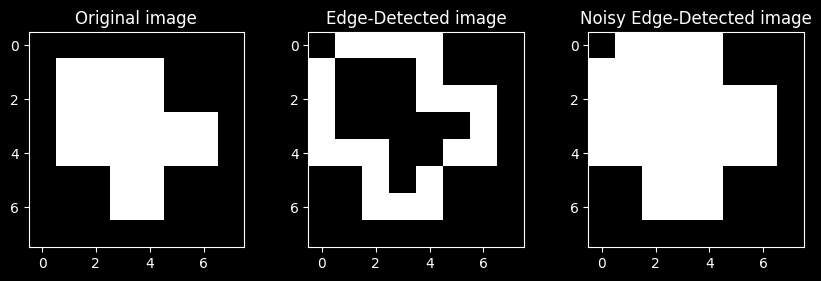

In [12]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image2 = h_edge_scan_img2 | v_edge_scan_img2

# Plotting the original, edge-detected, and noisy images

fig, axes = plt.subplots(1, 3, figsize=(10, 9))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image, cmap='gray')
axes[1].set_title('Edge-Detected image')
axes[1].axis('on')

axes[2].imshow(edge_scan_image2, cmap='gray')
axes[2].set_title('Noisy Edge-Detected image')
axes[2].axis('on')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal space between images

# Show the plot
plt.show()

In [13]:
Im1 = edge_scan_image
Im2 = edge_scan_image2
ImageDistance(Im1, Im2)

21.875

## Multiple bit-flip errors

In [18]:
noisy_qubit_list_h = [2, 4]
noisy_qubit_list_v = [3, 5]

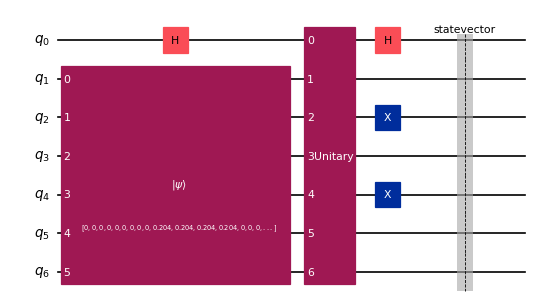

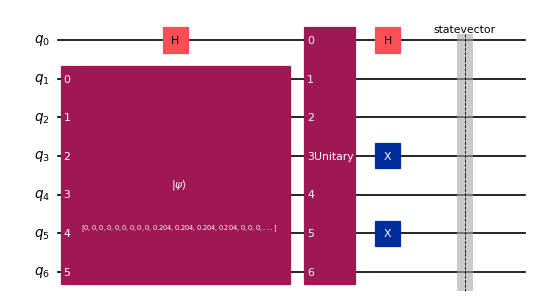

In [19]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_q)
qc_h.initialize(h_norm_image, range(1, total_q))
qc_h.h(0)
qc_h.unitary(Amp_permutation_unitary, range(total_q))
qc_h.h(0)

qc_h2 = qc_h.copy()

for q in noisy_qubit_list_h:      # Bit flip errors
  qc_h2.x(q)


qc_h.save_statevector()
qc_h2.save_statevector()

display(qc_h2.draw('mpl', fold=-1, scale = 0.6))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_q)
qc_v.initialize(v_norm_image, range(1, total_q))
qc_v.h(0)
qc_v.unitary(Amp_permutation_unitary, range(total_q))
qc_v.h(0)

qc_v2 = qc_v.copy()

for q in noisy_qubit_list_v:      # Bit flip errors
  qc_v2.x(q)


qc_v.save_statevector()
qc_v2.save_statevector()

display(qc_v2.draw('mpl', fold=-1, scale = 0.6))

# Combine both circuits into a single list
circ_list2 = [qc_h2, qc_v2]

# Simulating cirucits
simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list2).result()

state_vector_h2 = results.get_statevector(qc_h2)
state_vector_v2 = results.get_statevector(qc_v2)

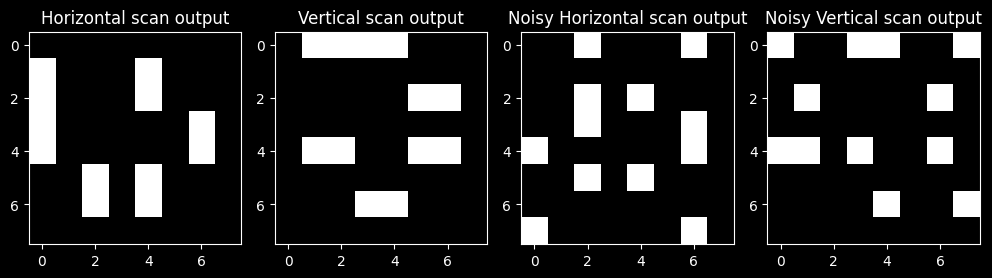

In [20]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img2 = np.abs(np.array([1 if threshold(state_vector_h2[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8)
v_edge_scan_img2= np.abs(np.array([1 if threshold(state_vector_v2[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Plot the images in the respective subplots
axes[0].imshow(h_edge_scan_img, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

axes[2].imshow(h_edge_scan_img2, cmap='gray')
axes[2].set_title('Noisy Horizontal scan output')
axes[2].axis('on')

axes[3].imshow(v_edge_scan_img2, cmap='gray')
axes[3].set_title('Noisy Vertical scan output')
axes[3].axis('on')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

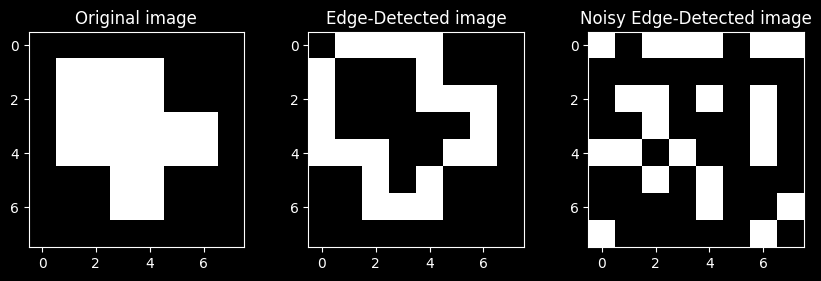

In [21]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image2 = h_edge_scan_img2 | v_edge_scan_img2

# Plotting the original, edge-detected, and noisy images

fig, axes = plt.subplots(1, 3, figsize=(10, 9))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image, cmap='gray')
axes[1].set_title('Edge-Detected image')
axes[1].axis('on')

axes[2].imshow(edge_scan_image2, cmap='gray')
axes[2].set_title('Noisy Edge-Detected image')
axes[2].axis('on')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal space between images

# Show the plot

plt.show()

In [22]:
Im1 = edge_scan_image
Im2 = edge_scan_image2
ImageDistance(Im1, Im2)

31.25

## Single phase flip error

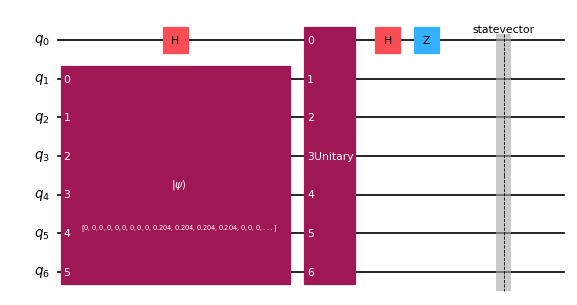

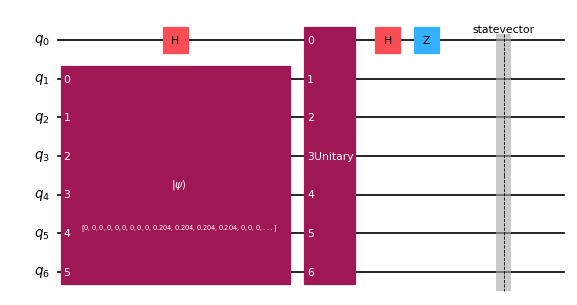

In [14]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_q)
qc_h.initialize(h_norm_image, range(1, total_q))
qc_h.h(0)
qc_h.unitary(Amp_permutation_unitary, range(total_q))
qc_h.h(0)

qc_h2 = qc_h.copy()
qc_h2.z(0)        # Phase flip error on the first qubit



qc_h.save_statevector()
qc_h2.save_statevector()

display(qc_h2.draw('mpl', fold=-1, scale = 0.6))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_q)
qc_v.initialize(v_norm_image, range(1, total_q))
qc_v.h(0)
qc_v.unitary(Amp_permutation_unitary, range(total_q))
qc_v.h(0)

qc_v2 = qc_v.copy()

qc_v2.z(0)        # Phase flip error on the first qubit

qc_v.save_statevector()
qc_v2.save_statevector()

display(qc_v2.draw('mpl', fold=-1, scale = 0.6))

# Combine both circuits into a single list
circ_list2 = [qc_h2, qc_v2]

# Simulating cirucits
simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list2).result()

state_vector_h2 = results.get_statevector(qc_h2)
state_vector_v2 = results.get_statevector(qc_v2)

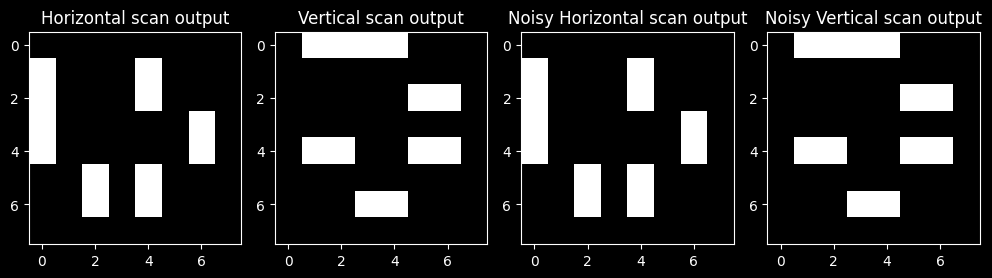

In [15]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img2 = np.abs(np.array([1 if threshold(state_vector_h2[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8)
v_edge_scan_img2= np.abs(np.array([1 if threshold(state_vector_v2[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Plot the images in the respective subplots
axes[0].imshow(h_edge_scan_img, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

axes[2].imshow(h_edge_scan_img2, cmap='gray')
axes[2].set_title('Noisy Horizontal scan output')
axes[2].axis('on')

axes[3].imshow(v_edge_scan_img2, cmap='gray')
axes[3].set_title('Noisy Vertical scan output')
axes[3].axis('on')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

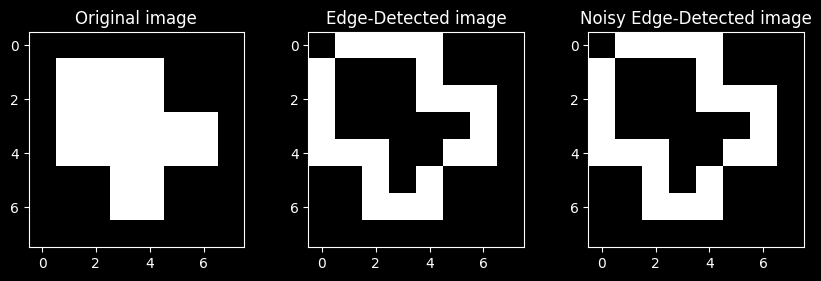

In [16]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image2 = h_edge_scan_img2 | v_edge_scan_img2

# Plotting the original, edge-detected, and noisy images

fig, axes = plt.subplots(1, 3, figsize=(10, 9))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image, cmap='gray')
axes[1].set_title('Edge-Detected image')
axes[1].axis('on')

axes[2].imshow(edge_scan_image2, cmap='gray')
axes[2].set_title('Noisy Edge-Detected image')
axes[2].axis('on')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal space between images

# Show the plot
plt.show()

In [17]:
Im1 = edge_scan_image
Im2 = edge_scan_image2
ImageDistance(Im1, Im2)

0.0

## Multiple phase-flip errors

In [23]:
noisy_qubit_list_h = [0, 2, 4]
noisy_qubit_list_v = [1, 3, 5]

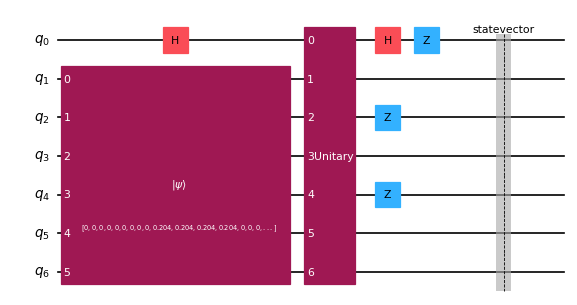

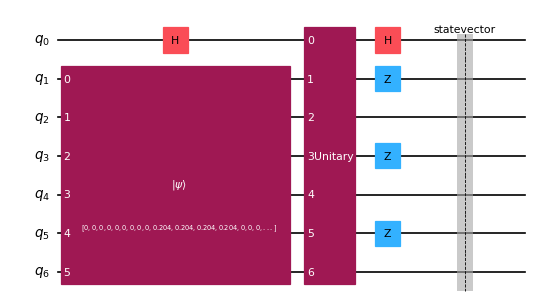

In [24]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_q)
qc_h.initialize(h_norm_image, range(1, total_q))
qc_h.h(0)
qc_h.unitary(Amp_permutation_unitary, range(total_q))
qc_h.h(0)

qc_h2 = qc_h.copy()

for q in noisy_qubit_list_h:      # Phase flip errors
  qc_h2.z(q)


qc_h.save_statevector()
qc_h2.save_statevector()

display(qc_h2.draw('mpl', fold=-1, scale = 0.6))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_q)
qc_v.initialize(v_norm_image, range(1, total_q))
qc_v.h(0)
qc_v.unitary(Amp_permutation_unitary, range(total_q))
qc_v.h(0)

qc_v2 = qc_v.copy()

for q in noisy_qubit_list_v:      # Phase flip errors
  qc_v2.z(q)


qc_v.save_statevector()
qc_v2.save_statevector()

display(qc_v2.draw('mpl', fold=-1, scale = 0.6))

# Combine both circuits into a single list
circ_list2 = [qc_h2, qc_v2]

# Simulating cirucits
simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list2).result()

state_vector_h2 = results.get_statevector(qc_h2)
state_vector_v2 = results.get_statevector(qc_v2)


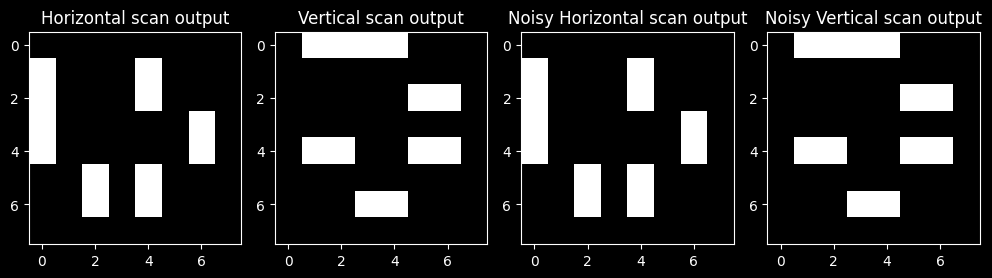

In [25]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img2 = np.abs(np.array([1 if threshold(state_vector_h2[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8)
v_edge_scan_img2= np.abs(np.array([1 if threshold(state_vector_v2[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Plot the images in the respective subplots
axes[0].imshow(h_edge_scan_img, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

axes[2].imshow(h_edge_scan_img2, cmap='gray')
axes[2].set_title('Noisy Horizontal scan output')
axes[2].axis('on')

axes[3].imshow(v_edge_scan_img2, cmap='gray')
axes[3].set_title('Noisy Vertical scan output')
axes[3].axis('on')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

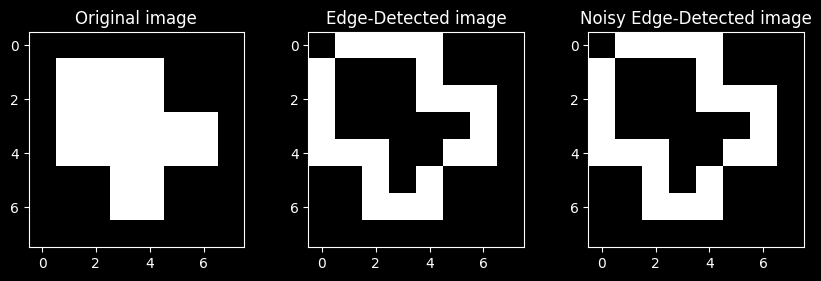

In [26]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image2 = h_edge_scan_img2 | v_edge_scan_img2

# Plotting the original, edge-detected, and noisy images

fig, axes = plt.subplots(1, 3, figsize=(10, 9))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image, cmap='gray')
axes[1].set_title('Edge-Detected image')
axes[1].axis('on')

axes[2].imshow(edge_scan_image2, cmap='gray')
axes[2].set_title('Noisy Edge-Detected image')
axes[2].axis('on')


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal space between images

# Show the plot

plt.show()

In [27]:
Im1 = edge_scan_image
Im2 = edge_scan_image2
ImageDistance(Im1, Im2)

0.0

# Large BW Image

In [28]:
from PIL import Image, ImageDraw

# Define the size of the image
width, height = 1024, 1024

# Create a new white image
image = Image.new('L', (width, height), color=255)

# Create a drawing object
draw = ImageDraw.Draw(image)

# Define the circle parameters
circle_radius = width // 4  # Circle radius (you can adjust this)
circle_center = (width // 2, height // 2)  # Circle center

# Draw the black circle
draw.ellipse(
    [circle_center[0] - circle_radius, circle_center[1] - circle_radius,
     circle_center[0] + circle_radius, circle_center[1] + circle_radius],
    fill=0  # Black color
)

# Save the image
image.save('circle_image.png')

# Optionally, display the image
image.show()


In [29]:
from PIL import Image
from numpy import asarray
image = Image.open('circle_image.png')
image.show()
new_image = image.resize((32, 32)).convert('1')
new_image.save('IMAGE_32.png')
new_image.show()
imgg=asarray(new_image)
print(imgg.shape)

(32, 32)


In [30]:
def plot_image(Image, title):
    plt.title(title)
    plt.xticks(range(Image.shape[0]))
    plt.yticks(range(Image.shape[1]))
    plt.imshow(Image, extent=[  0,Image.shape[0], Image.shape[1],0,], cmap='hot')
    plt.show()

def amplitude_encode(img_data):

    # Calculate the RMS value
    rms_32 = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))

    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms_32)

    # Return the normalized image as a numpy array
    return np.array(image_norm)


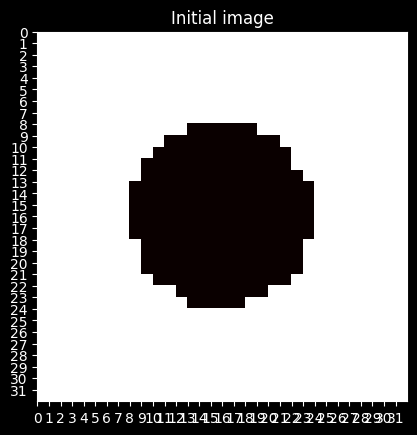

size= (32, 32)


In [31]:
plot_image(imgg, 'Initial image')
print("size=",imgg.shape)

In [32]:
#we now normalize image and get coefficients in both horizontal and vertical directions

h_norm_image_32 = amplitude_encode(imgg)    # Horizontal: Original image
v_norm_image_32 = amplitude_encode(imgg.T)  # Vertical: Transpose of Original image
print("Horizontal image normalized coefficients",h_norm_image_32)
print("vertical image normalized coefficients",v_norm_image_32)


print("size of 1d array",h_norm_image_32.shape)
print("size of 1d array",v_norm_image_32.shape)

Horizontal image normalized coefficients [0.03487901 0.03487901 0.03487901 ... 0.03487901 0.03487901 0.03487901]
vertical image normalized coefficients [0.03487901 0.03487901 0.03487901 ... 0.03487901 0.03487901 0.03487901]
size of 1d array (1024,)
size of 1d array (1024,)


In [33]:
data_q_32 = 10
ancillary_q_32 = 1
total_q_32 = data_q_32 + ancillary_q_32

# Initialize the amplitude permutation unitary
Amp_permutation_unitary_32 = np.identity(2**total_q_32)
Amp_permutation_unitary_32=np.roll(Amp_permutation_unitary_32,1,axis=1)
print("shift Amplitude permutation matrix by 1 unit to the right column wise")
print(Amp_permutation_unitary_32)
print("we will later use this for while applying hadamard operation to image coefficient vectors")
print(Amp_permutation_unitary_32.shape)

shift Amplitude permutation matrix by 1 unit to the right column wise
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]
we will later use this for while applying hadamard operation to image coefficient vectors
(2048, 2048)


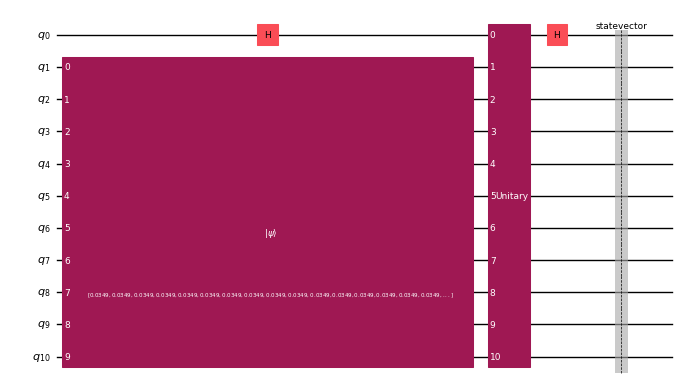

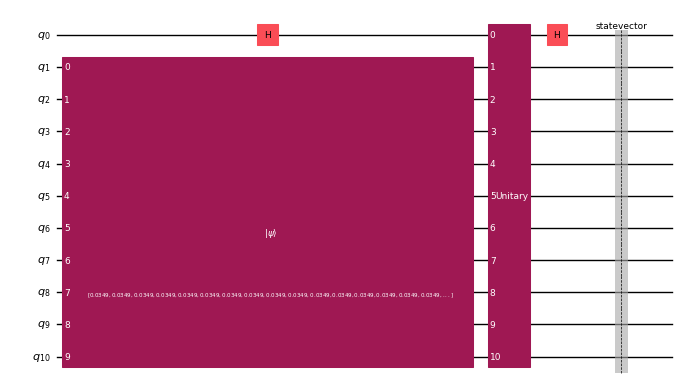

In [35]:
qc_h_32 = QuantumCircuit(total_q_32)
qc_h_32.initialize(h_norm_image_32, range(1, total_q_32))
qc_h_32.h(0)
qc_h_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_h_32.h(0)
qc_h_32.save_statevector()

display(qc_h_32.draw('mpl', fold=-1, scale = 0.5))


# Create the circuit for vertical scan
qc_v_32 = QuantumCircuit(total_q_32)
qc_v_32.initialize(v_norm_image_32, range(1, total_q_32))
qc_v_32.h(0)
qc_v_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_v_32.h(0)
qc_v_32.save_statevector()

display(qc_v_32.draw('mpl', fold=-1, scale = 0.5))

# Combine both circuits into a single list
circ_list_32 = [qc_h_32, qc_v_32]

# Simulating cirucits
simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list_32).result()

state_vector_h_32 = results.get_statevector(qc_h_32)
state_vector_v_32 = results.get_statevector(qc_v_32)

(-0.5, 31.5, 31.5, -0.5)

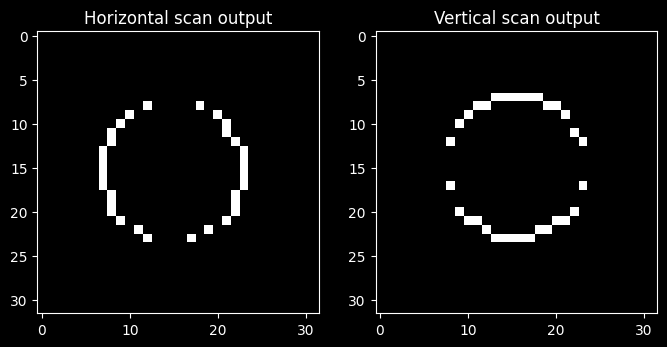

In [36]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img_32 = np.abs(np.array([1 if threshold(state_vector_h_32[2*(i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32)
v_edge_scan_img_32= np.abs(np.array([1 if threshold(state_vector_v_32[2*(i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(h_edge_scan_img_32, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img_32, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

(-0.5, 31.5, 31.5, -0.5)

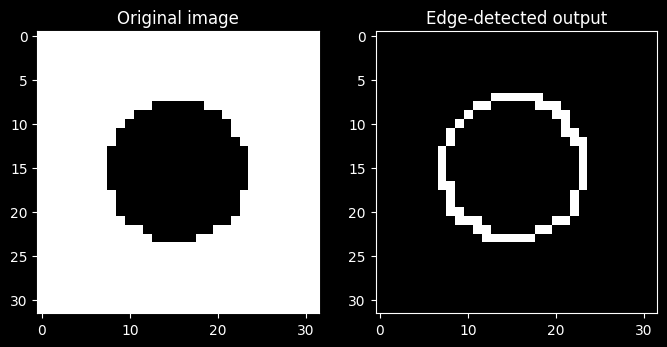

In [37]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image_32 = h_edge_scan_img_32 | v_edge_scan_img_32


# Plotting the original and edge-detected images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(imgg, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image_32, cmap='gray')
axes[1].set_title('Edge-detected output')
axes[1].axis('on')

## Single bit-flip error

In [44]:
noisy_qubit_list_32_h = [1]
noisy_qubit_list_32_v = [1]

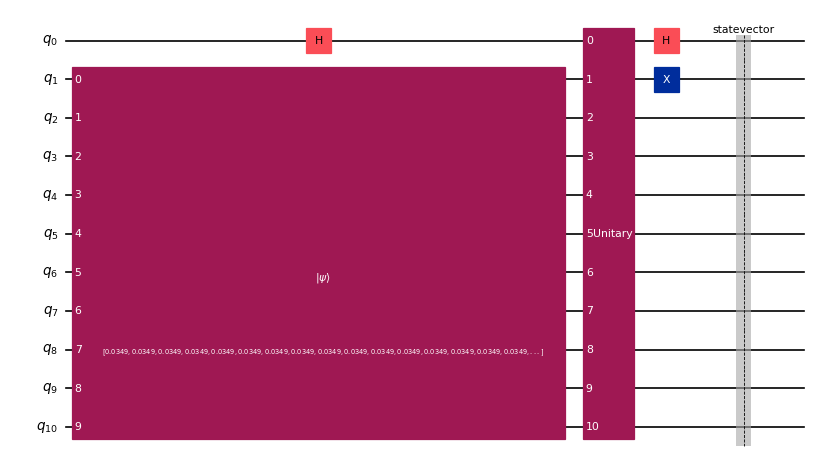

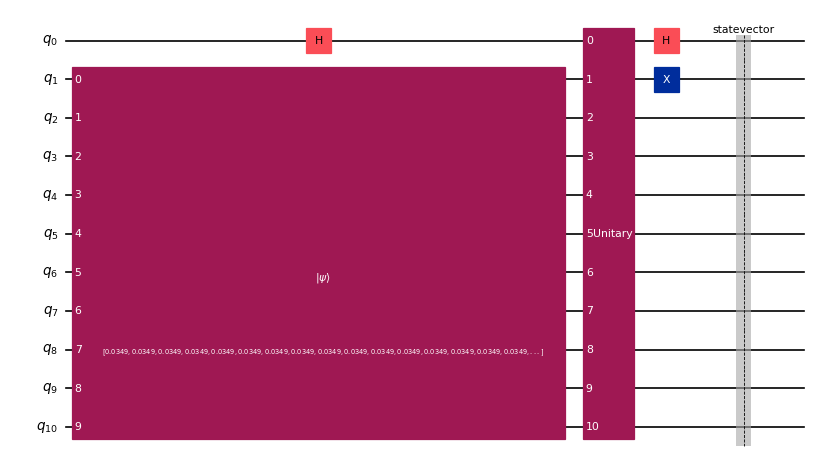

In [45]:
# Create the circuit for horizontal scan
qc_h_32 = QuantumCircuit(total_q_32)
qc_h_32.initialize(h_norm_image_32, range(1, total_q_32))
qc_h_32.h(0)
qc_h_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_h_32.h(0)

qc_h_32_noisy = qc_h_32.copy()

for q in noisy_qubit_list_32_h:      # Bit flip errors
  qc_h_32_noisy.x(q)


qc_h_32.save_statevector()
qc_h_32_noisy.save_statevector()

display(qc_h_32_noisy.draw('mpl', fold=-1, scale = 0.6))

# Create the circuit for vertical scan
qc_v_32 = QuantumCircuit(total_q_32)
qc_v_32.initialize(v_norm_image_32, range(1, total_q_32))
qc_v_32.h(0)
qc_v_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_v_32.h(0)

qc_v_32_noisy = qc_v_32.copy()

for q in noisy_qubit_list_32_v:      # Bit flip errors
  qc_v_32_noisy.x(q)


qc_v_32.save_statevector()
qc_v_32_noisy.save_statevector()

display(qc_v_32_noisy.draw('mpl', fold=-1, scale = 0.6))




# Combine both circuits into a single list
circ_list_32_noisy = [qc_h_32_noisy, qc_v_32_noisy]

# Simulating cirucits
simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list_32_noisy).result()

state_vector_h_32_noisy = results.get_statevector(qc_h_32_noisy)
state_vector_v_32_noisy = results.get_statevector(qc_v_32_noisy)


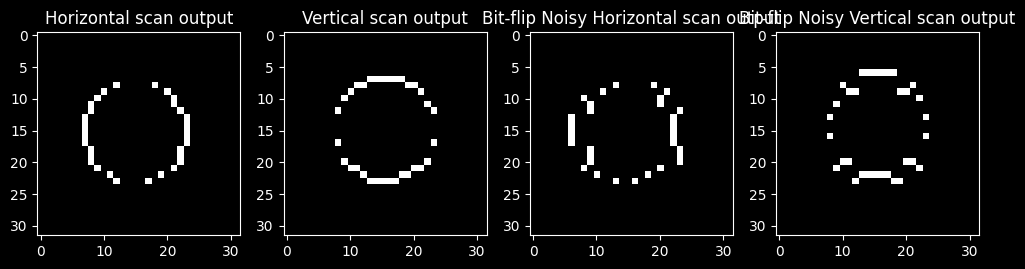

In [46]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img_32_noisy = np.abs(np.array([1 if threshold(state_vector_h_32_noisy[(2*i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32)
v_edge_scan_img_32_noisy= np.abs(np.array([1 if threshold(state_vector_v_32_noisy[(2*i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Plot the images in the respective subplots
axes[0].imshow(h_edge_scan_img_32, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img_32, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

axes[2].imshow(h_edge_scan_img_32_noisy, cmap='gray')
axes[2].set_title('Bit-flip Noisy Horizontal scan output')
axes[2].axis('on')

axes[3].imshow(v_edge_scan_img_32_noisy, cmap='gray')
axes[3].set_title('Bit-flip Noisy Vertical scan output')
axes[3].axis('on')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

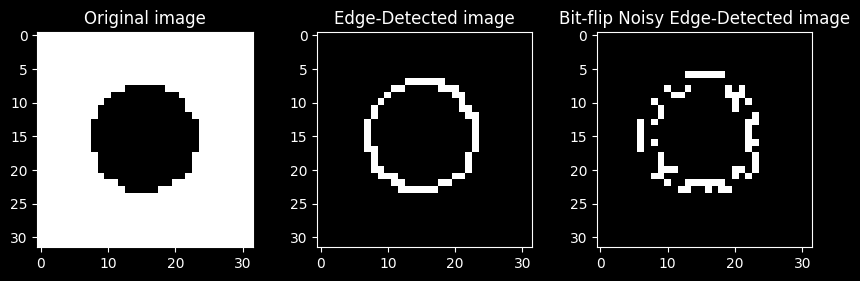

In [47]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image_32_noisy = h_edge_scan_img_32_noisy | v_edge_scan_img_32_noisy

# Plotting the original, edge-detected, and noisy images

fig, axes = plt.subplots(1, 3, figsize=(10, 9))

axes[0].imshow(imgg, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image_32, cmap='gray')
axes[1].set_title('Edge-Detected image')
axes[1].axis('on')

axes[2].imshow(edge_scan_image_32_noisy, cmap='gray')
axes[2].set_title('Bit-flip Noisy Edge-Detected image')
axes[2].axis('on')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal space between images

# Show the plot

plt.show()

In [48]:
Im1 = edge_scan_image_32
Im2 = edge_scan_image_32_noisy
ImageDistance(Im1, Im2)

8.88671875

## Mulitple bit-flip errors

In [49]:
noisy_qubit_list_32_h = [1,5,9]
noisy_qubit_list_32_v = [1,5,9]

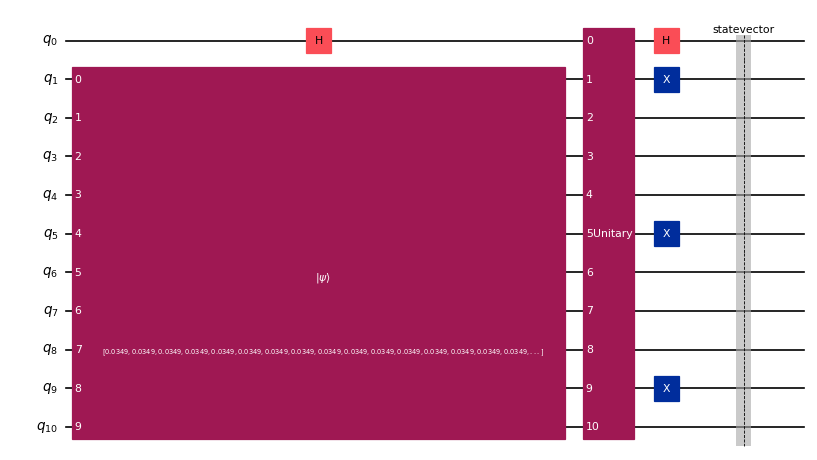

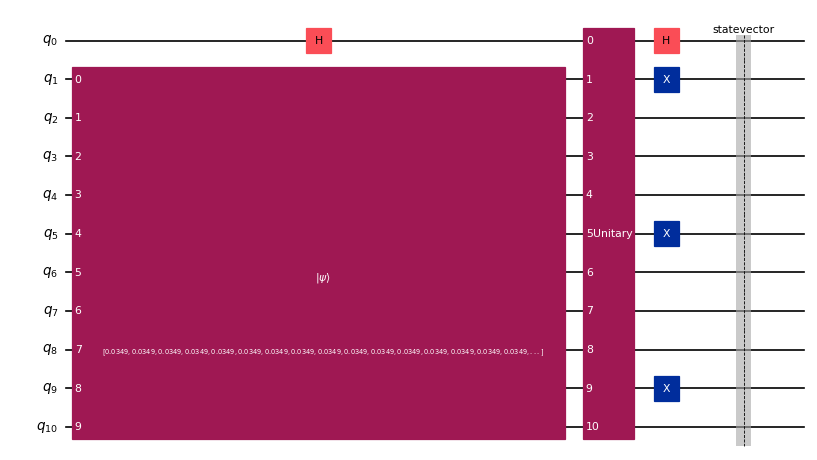

In [50]:
# Create the circuit for horizontal scan
qc_h_32 = QuantumCircuit(total_q_32)
qc_h_32.initialize(h_norm_image_32, range(1, total_q_32))
qc_h_32.h(0)
qc_h_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_h_32.h(0)

qc_h_32_noisy = qc_h_32.copy()

for q in noisy_qubit_list_32_h:      # Bit flip errors
  qc_h_32_noisy.x(q)


qc_h_32.save_statevector()
qc_h_32_noisy.save_statevector()

display(qc_h_32_noisy.draw('mpl', fold=-1, scale = 0.6))

# Create the circuit for vertical scan
qc_v_32 = QuantumCircuit(total_q_32)
qc_v_32.initialize(v_norm_image_32, range(1, total_q_32))
qc_v_32.h(0)
qc_v_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_v_32.h(0)

qc_v_32_noisy = qc_v_32.copy()

for q in noisy_qubit_list_32_v:      # Bit flip errors
  qc_v_32_noisy.x(q)


qc_v_32.save_statevector()
qc_v_32_noisy.save_statevector()

display(qc_v_32_noisy.draw('mpl', fold=-1, scale = 0.6))




# Combine both circuits into a single list
circ_list_32_noisy = [qc_h_32_noisy, qc_v_32_noisy]

# Simulating cirucits
simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list_32_noisy).result()

state_vector_h_32_noisy = results.get_statevector(qc_h_32_noisy)
state_vector_v_32_noisy = results.get_statevector(qc_v_32_noisy)


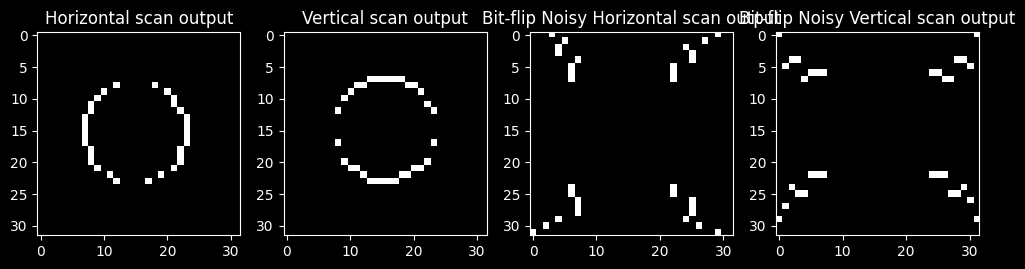

In [51]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img_32_noisy = np.abs(np.array([1 if threshold(state_vector_h_32_noisy[(2*i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32)
v_edge_scan_img_32_noisy= np.abs(np.array([1 if threshold(state_vector_v_32_noisy[(2*i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Plot the images in the respective subplots
axes[0].imshow(h_edge_scan_img_32, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img_32, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

axes[2].imshow(h_edge_scan_img_32_noisy, cmap='gray')
axes[2].set_title('Bit-flip Noisy Horizontal scan output')
axes[2].axis('on')

axes[3].imshow(v_edge_scan_img_32_noisy, cmap='gray')
axes[3].set_title('Bit-flip Noisy Vertical scan output')
axes[3].axis('on')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

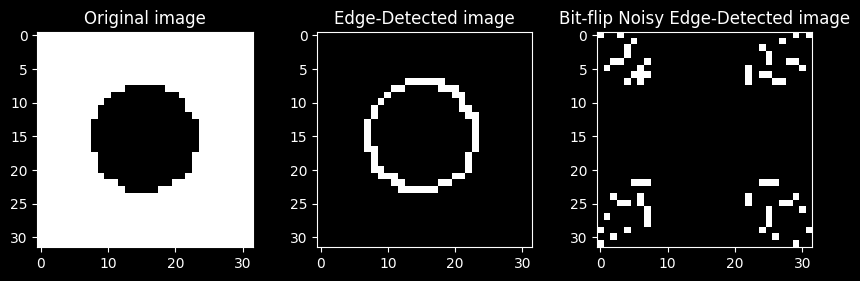

In [52]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image_32_noisy = h_edge_scan_img_32_noisy | v_edge_scan_img_32_noisy

# Plotting the original, edge-detected, and noisy images

fig, axes = plt.subplots(1, 3, figsize=(10, 9))

axes[0].imshow(imgg, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image_32, cmap='gray')
axes[1].set_title('Edge-Detected image')
axes[1].axis('on')

axes[2].imshow(edge_scan_image_32_noisy, cmap='gray')
axes[2].set_title('Bit-flip Noisy Edge-Detected image')
axes[2].axis('on')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal space between images

# Show the plot

plt.show()

In [53]:
Im1 = edge_scan_image_32
Im2 = edge_scan_image_32_noisy
ImageDistance(Im1, Im2)

11.5234375

## Single phase-flip error

In [55]:
noisy_qubit_list_32_h = [1]
noisy_qubit_list_32_v = [1]

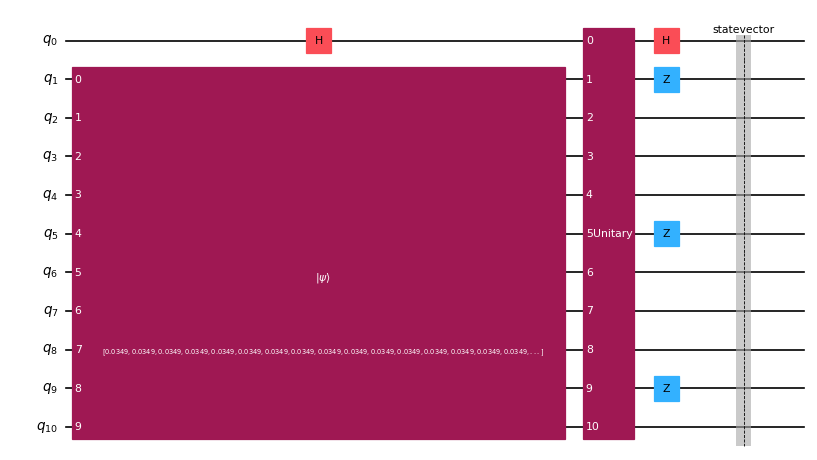

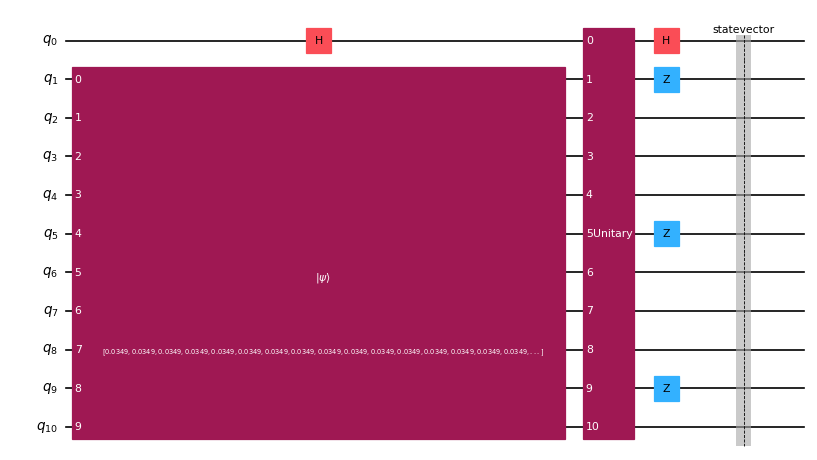

In [57]:
# Create the circuit for horizontal scan
qc_h_32 = QuantumCircuit(total_q_32)
qc_h_32.initialize(h_norm_image_32, range(1, total_q_32))
qc_h_32.h(0)
qc_h_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_h_32.h(0)

qc_h_32_noisy = qc_h_32.copy()

for q in noisy_qubit_list_32_h:      # Bit flip errors
  qc_h_32_noisy.z(q)


qc_h_32.save_statevector()
qc_h_32_noisy.save_statevector()

display(qc_h_32_noisy.draw('mpl', fold=-1, scale = 0.6))

# Create the circuit for vertical scan
qc_v_32 = QuantumCircuit(total_q_32)
qc_v_32.initialize(v_norm_image_32, range(1, total_q_32))
qc_v_32.h(0)
qc_v_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_v_32.h(0)

qc_v_32_noisy = qc_v_32.copy()

for q in noisy_qubit_list_32_v:      # Bit flip errors
  qc_v_32_noisy.z(q)


qc_v_32.save_statevector()
qc_v_32_noisy.save_statevector()

display(qc_v_32_noisy.draw('mpl', fold=-1, scale = 0.6))




# Combine both circuits into a single list
circ_list_32_noisy = [qc_h_32_noisy, qc_v_32_noisy]

# Simulating cirucits
simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list_32_noisy).result()

state_vector_h_32_noisy = results.get_statevector(qc_h_32_noisy)
state_vector_v_32_noisy = results.get_statevector(qc_v_32_noisy)


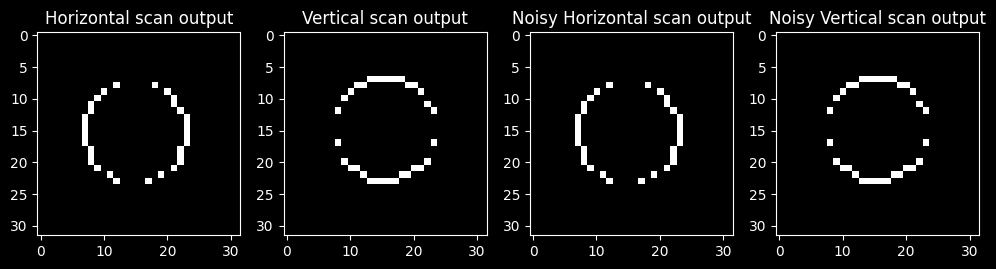

In [59]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img_32_noisy = np.abs(np.array([1 if threshold(state_vector_h_32_noisy[(2*i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32)
v_edge_scan_img_32_noisy= np.abs(np.array([1 if threshold(state_vector_v_32_noisy[(2*i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Plot the images in the respective subplots
axes[0].imshow(h_edge_scan_img_32, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img_32, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

axes[2].imshow(h_edge_scan_img_32_noisy, cmap='gray')
axes[2].set_title('Noisy Horizontal scan output')
axes[2].axis('on')

axes[3].imshow(v_edge_scan_img_32_noisy, cmap='gray')
axes[3].set_title('Noisy Vertical scan output')
axes[3].axis('on')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

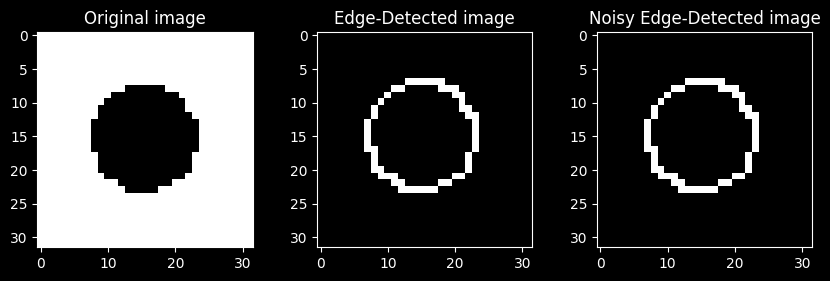

In [61]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image_32_noisy = h_edge_scan_img_32_noisy | v_edge_scan_img_32_noisy

# Plotting the original, edge-detected, and noisy images

fig, axes = plt.subplots(1, 3, figsize=(10, 9))

axes[0].imshow(imgg, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image_32, cmap='gray')
axes[1].set_title('Edge-Detected image')
axes[1].axis('on')

axes[2].imshow(edge_scan_image_32_noisy, cmap='gray')
axes[2].set_title('Noisy Edge-Detected image')
axes[2].axis('on')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal space between images

# Show the plot

plt.show()

In [64]:
Im1 = edge_scan_image_32
Im2 = edge_scan_image_32_noisy
ImageDistance(Im1, Im2)

0.0

## Multiple phase-flip errors

In [56]:
noisy_qubit_list_32_h = [1,5,9]
noisy_qubit_list_32_v = [1,5,9]

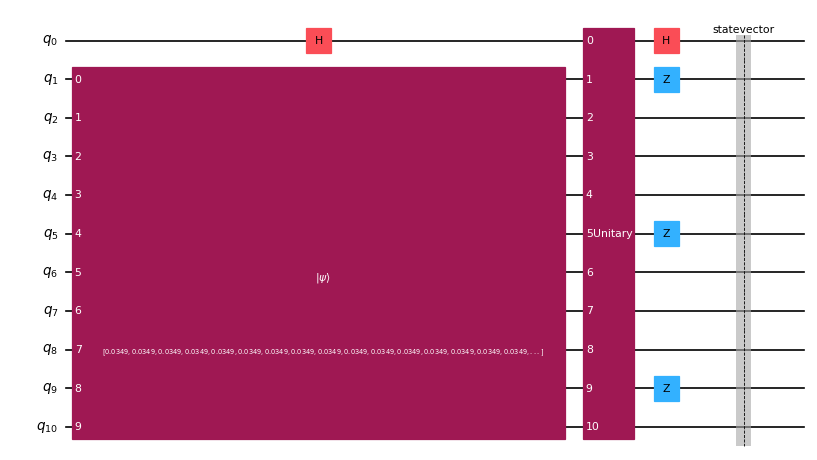

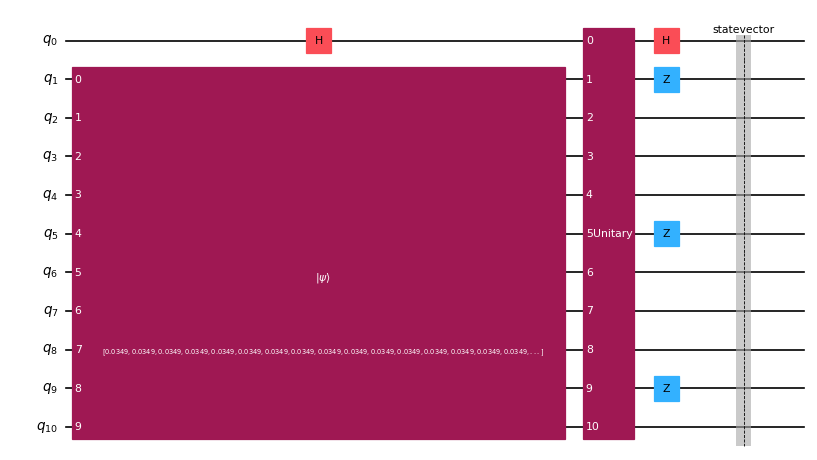

In [58]:
# Create the circuit for horizontal scan
qc_h_32 = QuantumCircuit(total_q_32)
qc_h_32.initialize(h_norm_image_32, range(1, total_q_32))
qc_h_32.h(0)
qc_h_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_h_32.h(0)

qc_h_32_noisy = qc_h_32.copy()

for q in noisy_qubit_list_32_h:      # Bit flip errors
  qc_h_32_noisy.z(q)


qc_h_32.save_statevector()
qc_h_32_noisy.save_statevector()

display(qc_h_32_noisy.draw('mpl', fold=-1, scale = 0.6))

# Create the circuit for vertical scan
qc_v_32 = QuantumCircuit(total_q_32)
qc_v_32.initialize(v_norm_image_32, range(1, total_q_32))
qc_v_32.h(0)
qc_v_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_v_32.h(0)

qc_v_32_noisy = qc_v_32.copy()

for q in noisy_qubit_list_32_v:      # Bit flip errors
  qc_v_32_noisy.z(q)


qc_v_32.save_statevector()
qc_v_32_noisy.save_statevector()

display(qc_v_32_noisy.draw('mpl', fold=-1, scale = 0.6))




# Combine both circuits into a single list
circ_list_32_noisy = [qc_h_32_noisy, qc_v_32_noisy]

# Simulating cirucits
simulator = AerSimulator(method = 'statevector')
results = simulator.run(circ_list_32_noisy).result()

state_vector_h_32_noisy = results.get_statevector(qc_h_32_noisy)
state_vector_v_32_noisy = results.get_statevector(qc_v_32_noisy)


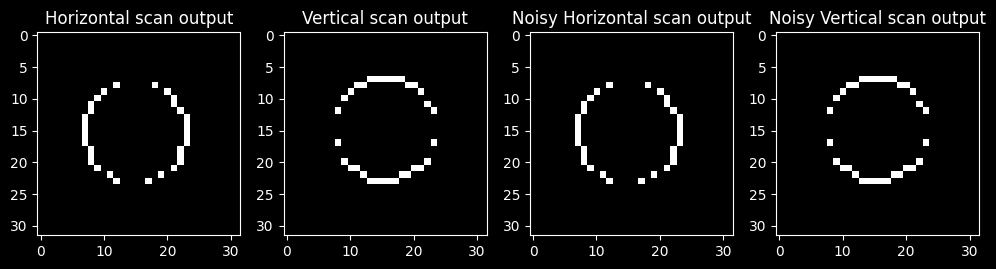

In [60]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img_32_noisy = np.abs(np.array([1 if threshold(state_vector_h_32_noisy[(2*i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32)
v_edge_scan_img_32_noisy= np.abs(np.array([1 if threshold(state_vector_v_32_noisy[(2*i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Plot the images in the respective subplots
axes[0].imshow(h_edge_scan_img_32, cmap='gray')
axes[0].set_title('Horizontal scan output')
axes[0].axis('on')

axes[1].imshow(v_edge_scan_img_32, cmap='gray')
axes[1].set_title('Vertical scan output')
axes[1].axis('on')

axes[2].imshow(h_edge_scan_img_32_noisy, cmap='gray')
axes[2].set_title('Noisy Horizontal scan output')
axes[2].axis('on')

axes[3].imshow(v_edge_scan_img_32_noisy, cmap='gray')
axes[3].set_title('Noisy Vertical scan output')
axes[3].axis('on')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

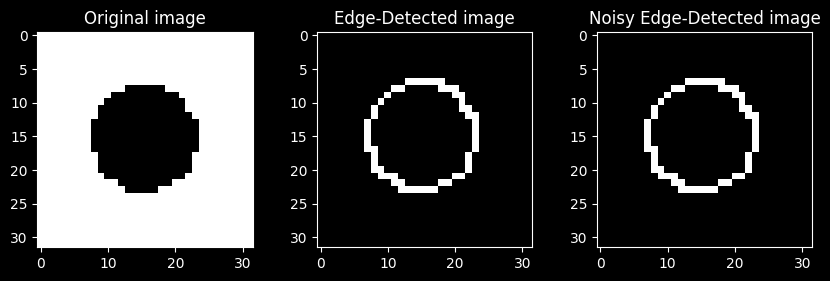

In [62]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image_32_noisy = h_edge_scan_img_32_noisy | v_edge_scan_img_32_noisy

# Plotting the original, edge-detected, and noisy images

fig, axes = plt.subplots(1, 3, figsize=(10, 9))

axes[0].imshow(imgg, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('on')

axes[1].imshow(edge_scan_image_32, cmap='gray')
axes[1].set_title('Edge-Detected image')
axes[1].axis('on')

axes[2].imshow(edge_scan_image_32_noisy, cmap='gray')
axes[2].set_title('Noisy Edge-Detected image')
axes[2].axis('on')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal space between images

# Show the plot

plt.show()

In [63]:
Im1 = edge_scan_image_32
Im2 = edge_scan_image_32_noisy
ImageDistance(Im1, Im2)

0.0